In [60]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv2D, Reshape, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
import os
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tqdm.notebook import tqdm
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [61]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
trainDir = '/content/drive/My Drive/ML Team 25/facial_expression_dataset_splited/train'
validDir = '/content/drive/My Drive/ML Team 25/facial_expression_dataset_splited/validate'
testDir = '/content/drive/My Drive/ML Team 25/facial_expression_dataset_splited/test'

In [63]:
def createDF(dir):
    images = []
    labels = []
    for label in os.listdir(dir):
        for image in os.listdir(os.path.join(dir,label)):
            images.append(os.path.join(dir,label,image))
            labels.append(label)
        print(label, "completed")
    return images,labels

In [64]:
trainDF = pd.DataFrame()
trainDF['image'], trainDF['label'] = createDF(trainDir)

sad completed
neutral completed
surprise completed
happy completed
disgust completed
angry completed
fear completed


In [65]:
print(trainDF)

                                                   image label
0      /content/drive/My Drive/ML Team 25/facial_expr...   sad
1      /content/drive/My Drive/ML Team 25/facial_expr...   sad
2      /content/drive/My Drive/ML Team 25/facial_expr...   sad
3      /content/drive/My Drive/ML Team 25/facial_expr...   sad
4      /content/drive/My Drive/ML Team 25/facial_expr...   sad
...                                                  ...   ...
24497  /content/drive/My Drive/ML Team 25/facial_expr...  fear
24498  /content/drive/My Drive/ML Team 25/facial_expr...  fear
24499  /content/drive/My Drive/ML Team 25/facial_expr...  fear
24500  /content/drive/My Drive/ML Team 25/facial_expr...  fear
24501  /content/drive/My Drive/ML Team 25/facial_expr...  fear

[24502 rows x 2 columns]


In [66]:
validDF = pd.DataFrame()
validDF['image'], validDF['label'] = createDF(validDir)

fear completed
happy completed
sad completed
angry completed
disgust completed
surprise completed
neutral completed


In [67]:
testDF = pd.DataFrame()
testDF['image'], testDF['label'] = createDF(testDir)

sad completed
surprise completed
disgust completed
happy completed
neutral completed
fear completed
angry completed


In [68]:
def extractFeatures(images):
  features = []
  for image in tqdm(images):
    img = load_img(image, color_mode='grayscale')
    img = img_to_array(img)
    features.append(img)
  features = np.array(features)
  features = features.reshape(len(features), 48, 48, 1)
  return features

In [69]:
trainFeatures = extractFeatures(trainDF['image'])

  0%|          | 0/24502 [00:00<?, ?it/s]

In [70]:
validFeatures = extractFeatures(validDF['image'])

  0%|          | 0/4319 [00:00<?, ?it/s]

In [71]:
testFeatures = extractFeatures(testDF['image'])

  0%|          | 0/7066 [00:00<?, ?it/s]

In [72]:
x_train = trainFeatures/255.0
x_valid = validFeatures/255.0
x_test = testFeatures/255.0

In [73]:
labelEncoder = LabelEncoder()
labelEncoder.fit(trainDF['label'])

LabelEncoder()

In [74]:
y_train = labelEncoder.transform(trainDF['label'])
y_valid = labelEncoder.transform(validDF['label'])
y_test = labelEncoder.transform(testDF['label'])

In [75]:
y_train = to_categorical(y_train, num_classes = 7)
y_valid = to_categorical(y_valid, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [76]:
#Note: maybe try to freeze some layers for transfer learning

In [77]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
input_tensor = Input(shape=(48, 48, 1))
x = Conv2D(3, (3, 3), padding='same')(input_tensor)
x = Reshape((48, 48, 3))(x)
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=predictions)

In [78]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

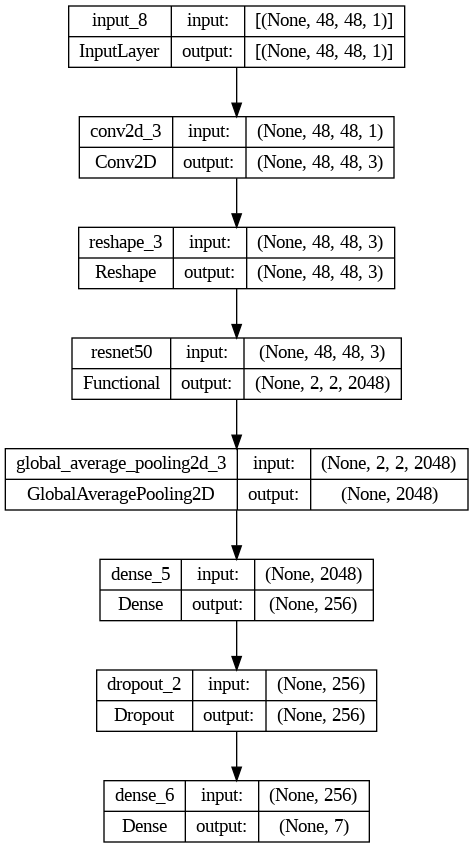

In [79]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [80]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 3)         30        
                                                                 
 reshape_3 (Reshape)         (None, 48, 48, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 256)               524544    
                                                           

In [81]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.002,
                               patience=3,
                               mode='min',
                               restore_best_weights=True)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=10,
    validation_data=(x_valid, y_valid),
    callbacks=[early_stopping]  # Add early stopping here
)
model.save('fcr_cnn_mar3_mine_on_orig.h5')

Epoch 1/10
 71/766 [=>............................] - ETA: 54:25 - loss: 2.5006 - accuracy: 0.2126

In [ ]:
df = pd.DataFrame(model.history.history)
df

In [ ]:
# Create a figure with 7 subplots (one for each metric)
fig, axs = plt.subplots(7, 1, figsize=(5, 25))  # 7 rows, 1 column

# List of metrics to plot
metrics = ['loss', 'accuracy', 'precision', 'recall', 'AUCPR', 'AUCROC','f1_score']
# take out 'f1_score'

for i, metric in enumerate(metrics):
    # Plot training metric
    axs[i].plot(df.index, df[metric], label=f'Training {metric}', marker='o')

    # Plot validation metric
    val_metric = f'val_{metric}'
    axs[i].plot(df.index, df[val_metric], label=f'Validation {metric}', linestyle='--', marker='x')

    axs[i].set_title(f'{metric} over epochs')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel(metric)
    axs[i].legend()

# Adjust layout for better fit
plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)